# Visualização do funcionamento do algoritmo do Kapetanovic

Esse jupyter tem como objetivo verificar o funcionamento do esquema de detecção de contaminação piloto 1B do artigo do Kapetanovic. O esquema é baseado na razão dos dois maiores autovalores da matriz R. Vamos ver como essa razão é alterada em função do número de usuários conectados na rede, qtd de antenas, SNR, e qtd de símbolos na sequência piloto.

### Importações

O arquivo "comm" possui as funções necessárias para simular a modulação QPSK, adicionar ruído branco na transmissão, e, por último, uma função que constroi a matriz R e retorna a razão de seus dois maiores autovalores.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import sys
from IPython.display import display, clear_output

sys.path.append("../Python/")
import comm

In [2]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10, 5],
    'figure.titlesize': 12, 
    'axes.labelsize': 8,
    'axes.titlesize': 10, 
    'font.size': 8,
    'legend.fontsize': 8, 
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

### Definição de Funções

In [3]:
def simularPropagacaoSinal(qtdSimbolosPiloto, bitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snr, qtdEspioes=1):
    
    # SIMULANDO OS CANAIS DO USUARIO E DO ESPIAO
    Haut = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)) + 1j*np.random.normal(0, 1, size=(qtdAntenas, qtdUsuarios)))
    g    = np.sqrt(0.5)*(np.random.normal(0, 1, size=(qtdAntenas, qtdEspioes)) + 1j*np.random.normal(0, 1, (qtdAntenas, qtdEspioes)))

    # SEQUENCIA PILOTO ALEATORIA + MODULACAO PARA TODOS OS USUARIOS:
    bitStream = np.random.choice([0, 1], qtdSimbolosPiloto*bitsPorSimbolo*qtdUsuarios)
    symb      = comm.qpskmodulator(bitStream) # QPSK Modulator
    xp        = symb.reshape(qtdUsuarios, qtdSimbolosPiloto)

    # ESPIAO ENTRANDO NA JOGADA (SE A POTENCIA DELE FOR 0 ELE NAO ENTRA NA JOGADA):
    xpe  = np.sqrt(potenciaEspiao)*xp[0, :] # xpe vai ser a sequencia piloto do primeiro usuario multiplicada pela raiz da potencia do espiao
    xptx = np.concatenate((xp, [xpe])) # xptx sera a matriz xp com uma linha a mais: xpe
    H    = np.concatenate((Haut, g), axis=1) # H vai ser Haut com uma COLUNA a mais, que vai ser g

    # TRANSMISSAO PELO CANAL
    Y = np.dot(H, xptx) # fading
    Y = comm.awgn(Y, SNR=snr) # ruido branco
    
    return Y, xp, H[:,0]

In [4]:
def estimarCanal(Y, xp):
    # HEST =(Y * xptranspostoconjugado ) * ((xp*xptranspconj)^(-1))
    # HEST -> cada coluna um usuario. No caso de um único usuário pegar a primeira coluna
    # return Hest(coluna 0)
    
    Hest = np.matmul(np.matmul(Y, np.conjugate(xp).T), np.linalg.inv(np.matmul(xp, np.conjugate(xp).T)))
    return Hest[:,0]

In [5]:
def mse(HestCol0, HCol0):
    pass
    # HestCol0 é o da função de cima mas só a primeira coluna
    # HCol0 é a primeira coluna do hzão 
    # comparar os elementos desses vetores pra fazer o mse
    return np.sum(((HestCol0 - HCol0).real)**2)/len(HestCol0)

### Verificando o MSE em função da SNR

In [6]:
# PARAMETROS
qtdEspioes        = 1
qtdBitsPorSimbolo = 2
repetibilidade    = 10
potenciaUsuario   = 1
qtdUsuarios       = 1
qtdAntenas        = 200
potenciaEspiao    = 0
qtdSimbolos       = 100
rangeSNRs         = np.arange(-10, 21, 2.5)

# VARIANDO AS SNRS
somaMSEsCadaSNR = []
for snrAtual in rangeSNRs:
    
    # REPETIBILIDADE
    somaMSESNRAtual = 0
    for i in range(repetibilidade):
        
        # PROPAGACAO DO SINAL
        Y, xp, HCol0 = simularPropagacaoSinal(qtdSimbolos, qtdBitsPorSimbolo, qtdAntenas, qtdUsuarios, potenciaEspiao, snrAtual, qtdEspioes)
        
        # ESTIMATIVA DO CANAL
        HestCol0 = estimarCanal(Y, xp)
        
        # MSE
        somaMSESNRAtual += mse(HestCol0, HCol0)
        
    # COLOCO A SOMA DOS MSE DESSA SNR NO ARRAY
    somaMSEsCadaSNR.append(somaMSESNRAtual/repetibilidade)

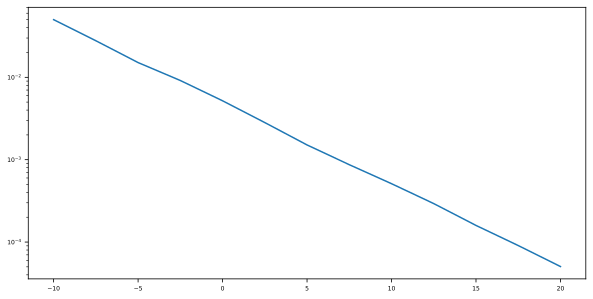

In [9]:
plt.plot(rangeSNRs, somaMSEsCadaSNR)
plt.yscale("log")